In [ ]:
"""
更新予定
メリステムの境界条件を柔軟に決定できるようにする
  境界条件を2つ設定．既存のシミュレーション境界とメリステム境界

  時間変化及び，要素の値によって動的にメリステム境界を変化させたい．
  -> 境界外側を0で固定するのではなく，各ステップで内外の判定条件を作成する
  境界が内側に移動する場合と外側に内側に変化する場合で，分岐をさせると，自然ではない．
  よって，要素が0の場合には，内側の座標の値をコピーする．
  その後に境界外側の要素を0にする処理とする．


メリステム境界の判定と，メリステム境界の移動は異なる関数とする．
移動関数の後に，判定関数？

判定関数について
  どの要素を基準に境界を変化させるかについて，未定
  そこで，時間変化，力学的変化，要素変化など，後からパラメータを追加できるようにする．

  妥当だと考えられる，簡単な式で記述したい

    各要素の大きさ(最大値 - wusp)と，メリステムにおける相対的な位置
    但し，PZで分裂しにくい事を含めると，複雑となる．

    とりあえず，メリステム中心からのユークリッド距離を求めて，それを重みとして含める事とする．


更新箇所




今後

パラメータセット
いくつかの指標により手動で調整

wusrやwuspのdegredation rate を含むべき？


楕円の外の黄色線不要
各seedpointsに対応させて，面積を求める．
この面積はステップごとに分岐をせまられる．
  2倍より大きい　->　分裂    or   大きくする．



細胞分裂の再現 (動的な変化)
時間変化に対して，細胞の大きさが変化する(何をindexとするか?)
細胞の面積を近似計算によって求める．
面積が一定の大きさ(e.x. 2倍)になると分裂させる．

---外側は境界条件，固定されている---

外側も動的に変化させたい．


再考及びtask

微分方程式の離散化について，正当性の検証
離散式の記述を，分かりやすく

単にwus0を前の状態として入れてあるが、よいか？

楕円の境界条件，単にある点が楕円内にあるかどうかで判断
"""


'\n更新予定\nメリステムの境界条件を柔軟に決定できるようにする\n  境界条件を2つ設定．既存のシミュレーション境界とメリステム境界\n\n  時間変化及び，要素の値によって動的にメリステム境界を変化させたい．\n  -> 境界外側を0で固定するのではなく，各ステップで内外の判定条件を作成する\n  境界が内側に移動する場合と外側に内側に変化する場合で，分岐をさせると，自然ではない．\n  よって，要素が0の場合には，内側の座標の値をコピーする．\n  その後に境界外側の要素を0にする処理とする．\n\n\nメリステム境界の判定と，メリステム境界の移動は異なる関数とする．\n移動関数の後に，判定関数？\n\n判定関数について\n  どの要素を基準に境界を変化させるかについて，未定\n  そこで，時間変化，力学的変化，要素変化など，後からパラメータを追加できるようにする．\n\n  妥当だと考えられる，簡単な式で記述したい\n\n    各要素の大きさ(最大値 - wusp)と，メリステムにおける相対的な位置\n    但し，PZで分裂しにくい事を含めると，複雑となる．\n\n    とりあえず，メリステム中心からのユークリッド距離を求めて，それを重みとして含める事とする．\n\n\n更新箇所\n\n\n\n\n今後\n\nパラメータセット\nいくつかの指標により手動で調整\n\nwusrやwuspのdegredation rate を含むべき？\n\n\n楕円の外の黄色線不要\n各seedpointsに対応させて，面積を求める．\nこの面積はステップごとに分岐をせまられる．\n  2倍より大きい\u3000->\u3000分裂    or   大きくする．\n\n\n\n細胞分裂の再現 (動的な変化)\n時間変化に対して，細胞の大きさが変化する(何をindexとするか?)\n細胞の面積を近似計算によって求める．\n面積が一定の大きさ(e.x. 2倍)になると分裂させる．\n\n---外側は境界条件，固定されている---\n\n外側も動的に変化させたい．\n\n\n再考及びtask\n\n微分方程式の離散化について，正当性の検証\n離散式の記述を，分かりやすく\n\n単にwus0を前の状態として入れてあるが、よいか？\n\n楕円の境界条件，単にある点が楕円内にある

In [ ]:
"""変数の命名規則について
小文字のkはそのまま、大文字のKをTに置換する





"""

'変数の命名規則について\n小文字のkはそのまま、大文字のKをTに置換する\n\n\n\n\n\n'

In [ ]:
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
import re
import pandas as pd
from PIL import Image, ImageDraw
import io
import IPython.display as display
from collections import defaultdict
import sys
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from numba import jit, njit
import cProfile
import pstats

from google.colab import files
from google.colab import drive

# ドライブのマウント
drive.mount('/content/drive')
Sim_data = pd.read_csv('drive/My Drive/Colab Notebooks/Diffusion-ish/Mesh-type/Sim_Param.csv')

# パラメータの読み込み
abc_idx, abc_par = Sim_data[1:1], Sim_data[0:1]

param_name = []
for n in abc_idx:
    param_name.append(n[0:4])

# pd 1row
param_ori = list(Sim_data.iloc[0])

ID, T_CW, n_CW, k_Cr, T_CL, n_CL, T_CH, n_CH, k_Cp, b_Cp, b_Cr, k_WL, k_WC, k_Wr, T_WW, n_WW, \
T_WL, n_WL, T_WC, n_WC, k_Wp, b_Wp, b_Wr, ki_W, a_Cc, T_HW, n_HW, b_pp, k_pp, \
b_Hh, k_Hh, k_Ll, b_Ll, D_Ww, D_Cc, D_Ll = param_ori[:36]

# 注意: param_ori の長さが34未満の場合、エラーが発生します。Sim_Param.csvのパラメータ数を確認してください。


# 初期設定
wr_sigma11, wr_sigma22, wr_sigma12, wr_sigma21 = 900, 300, 0, 0
wp_sigma11, wp_sigma22, wp_sigma12, wp_sigma21 = 900, 300, 0, 0
cr_sigma11, cr_sigma22, cr_sigma12, cr_sigma21 = 200, 150, 0, 0
cp_sigma11, cp_sigma22, cp_sigma12, cp_sigma21 = 100, 50, 0, 0
eL_sigma11, eL_sigma22, eL_sigma12, eL_sigma21 = 60, 30, 0, 0
eR_sigma11, eR_sigma22, eR_sigma12, eR_sigma21 = 60, 30, 0, 0
h_sigma11, h_sigma22, h_sigma12, h_sigma21 = 10, 10, 0, 0

# 各成分のσ行列
sigma11 = [9, 9, 5, 5, 6, 6, 1]
sigma22 = [3, 3, 1.5, 1.5, 3, 3, 1]
sigma12 = [0, 0, 0, 0, 0, 0, 0]
sigma21 = [0, 0, 0, 0, 0, 0, 0]


mu_wusr_x, mu_wusr_y = 7.5, 2.5
mu_wusp_x, mu_wusp_y = 7.5, 2.5
mu_clvr_x, mu_clvr_y = 7.5, 7.5
mu_clvp_x, mu_clvp_y = 7.5, 7.5
mu_erfL_x, mu_erfL_y = 4, 5
mu_erfR_x, mu_erfR_y = 11, 5
mu_ham_x, mu_ham_y = 7.5, 2.5

element_str = ["wusr", "wusp", "clvr", "clvp", "erfL", "erfR", "ham"]

# 空間設定
x_size, y_size = 15, 10
x_max, y_max = x_size, y_size  # range
dx, dy = 0.1, 0.1  # divide

# 楕円のパラメータ設定
ellip_long = 7  # 楕円の長軸の半径
ellip_short = 6  # 楕円の短軸の半径
ellip_x = 7.5  # 楕円の中心 x 座標
ellip_y = 3  # 楕円の中心 y 座標

global_seed_points = None

# Amplifier
wr_AMP, wp_AMP, cr_AMP, cp_AMP, eL_AMP, eR_AMP, h_AMP = 600, 150, 300, 150, 300, 300, 10

a = 1   # diffusion rate

# 計算条件
dt = 0.0005  # Time
step = 10
result_interval = 5

# プロット設定
plsv_wusr, plsv_wusp, plsv_clvr, plsv_clvp, plsv_erfL, plsv_erfR, plsv_ham = 1, 1, 1, 1, 1, 1, 1

# 成分名とカラーマップ
wusr_str, wusp_str, clvr_str, clvp_str, erfL_str, erfR_str, ham_str = 'wusr', 'wusp', 'clvr', 'clvp', 'epflL', 'epflR', 'ham'
c_wusr, c_wusp, c_clvr, c_clvp, c_erfL, c_erfR, c_ham = 'jet', 'seismic', 'twilight_shifted', 'CMRmap', 'cividis', 'plasma', 'terrain'

# 引数リスト
pull_sol = [dt, dx, dy, a, step, result_interval]

# GIF用の画像ストック
keys_name = ["wusr", "wusp", "clvr", "clvp", "erfL", "erfR", "ham"]
img_stock = defaultdict(list)

# 指定されたキーを追加
for key in keys_name:
    img_stock[key]  # defaultdictにキーを生成


Mounted at /content/drive


In [ ]:
def initial_field(x, y):
    # 各成分に対応するゼロ行列を生成
    zero_wusr, zero_wusp, zero_clvr, zero_clvp, zero_erfL, zero_erfR, zero_ham = [np.zeros((len(y), len(x))) for _ in range(7)]

    # 2D Gaussian(sigma:分散共分散行列, mu:平均ベクトル)
    wr_sigma, wp_sigma, cr_sigma, cp_sigma, eL_sigma, eR_sigma, h_sigma = [
        np.array([[a, b], [c, d]]) for a, b, c, d in zip(sigma11, sigma12, sigma21, sigma22)
    ]

    # 各成分の行列式と逆行列を計算
    wr_det_sigma, wr_inv_sigma = np.linalg.det(wr_sigma), np.linalg.inv(wr_sigma)
    wp_det_sigma, wp_inv_sigma = np.linalg.det(wp_sigma), np.linalg.inv(wp_sigma)
    cr_det_sigma, cr_inv_sigma = np.linalg.det(cr_sigma), np.linalg.inv(cr_sigma)
    cp_det_sigma, cp_inv_sigma = np.linalg.det(cp_sigma), np.linalg.inv(cp_sigma)
    eL_det_sigma, eL_inv_sigma = np.linalg.det(eL_sigma), np.linalg.inv(eL_sigma)
    eR_det_sigma, eR_inv_sigma = np.linalg.det(eR_sigma), np.linalg.inv(eR_sigma)
    h_det_sigma, h_inv_sigma = np.linalg.det(h_sigma), np.linalg.inv(h_sigma)

    # Gaussian分布を計算する関数
    def get_arr(z, xtemp, ytemp, det_sigma, inv_sigma, AMPP):
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))
        arr = np.array([xtemp, ytemp])

        Z = (1 / (2 * np.pi * np.sqrt(det_sigma))) * np.exp(
            -0.5 * np.einsum('...k,kl,...l->...', pos - arr, inv_sigma, pos - arr)
        ) * AMPP
        return Z

    # 各変数のリストを作成
    zero_list = [zero_wusr, zero_wusp, zero_clvr, zero_clvp, zero_erfL, zero_erfR, zero_ham]
    mu_x_list = [mu_wusr_x, mu_wusp_x, mu_clvr_x, mu_clvp_x, mu_erfL_x, mu_erfR_x, mu_ham_x]
    mu_y_list = [mu_wusr_y, mu_wusp_y, mu_clvr_y, mu_clvp_y, mu_erfL_y, mu_erfR_y, mu_ham_y]
    det_list = [wr_det_sigma, wp_det_sigma, cr_det_sigma, cp_det_sigma, eL_det_sigma, eR_det_sigma, h_det_sigma]
    inv_list = [wr_inv_sigma, wp_inv_sigma, cr_inv_sigma, cp_inv_sigma, eL_inv_sigma, eR_inv_sigma, h_inv_sigma]
    AMP_list = [wr_AMP, wp_AMP, cr_AMP, cp_AMP, eL_AMP, eR_AMP, h_AMP]

    # 各成分のGaussian分布を計算
    zzz_wusr, zzz_wusp, zzz_clvr, zzz_clvp, zzz_erfL, zzz_erfR, zzz_ham = [
        get_arr(a, b, c, d, e, f) for a, b, c, d, e, f in zip(zero_list, mu_x_list, mu_y_list, det_list, inv_list, AMP_list)
    ]

    # 計算結果を返す
    return zzz_wusr, zzz_wusp, zzz_clvr, zzz_clvp, zzz_erfL, zzz_erfR, zzz_ham

def boundary_condition(a):
    a[:, 0], a[:, -1], a[0, :], a[-1, :] = 0, 0, 0, 0  # left, right, up, bottom
    return a

def apply_boundary_conditions(values, mask):
    """
    境界条件を適用する関数。
    境界外の要素を0に設定し、必要に応じて内側の値をコピーする。
    """
    # 境界外の要素を0に設定
    values[~mask] = 0
    return values

def meristem_boundary_mask(x, y, center_x, center_y, radius_func, element_values=None, threshold=None):
    """
    楕円形のメリステム境界マスクを作成する関数。
    """
    X, Y = np.meshgrid(x, y)
    # 楕円形の距離計算
    a = ellip_long  # 長軸半径
    b = ellip_short  # 短軸半径
    distance = np.sqrt(((X - center_x) / a)**2 + ((Y - center_y) / b)**2)
    radius = radius_func()
    mask = distance <= (radius / a)  # 正規化して楕円内をマスク
    if element_values is not None and threshold is not None:
        mask = mask & (element_values >= threshold)
    return mask

def outer_boundary_mask(x, y, center_x, center_y, outer_radius_func):
    """
    外側の境界マスクを作成する関数。
    outer_radius_funcは時間や要素の値に応じて外側の半径を返す関数。
    """
    X, Y = np.meshgrid(x, y)
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    outer_radius = outer_radius_func()
    mask = distance <= outer_radius
    return mask

def radius_func(n):
    """
    時間ステップnに応じてメリステムの半径を計算する関数。
    例として、ステップごとに半径が0.01ずつ増加するモデル。
    """
    initial_radius = 6.5  # 初期半径（必要に応じて調整）
    expansion_rate = 0.01  # 半径の増加率
    return initial_radius + expansion_rate * n

def seed_points_maker(ellip_x, ellip_y, ellip_long, ellip_short, num_L1=30, num_L2=40, num_L3=50, shrink_factor=0.8):
    """
    楕円内のポイントを L1, L2, L3 層に分けて生成する
    L1, L2 cell の大きさが同じくらいになるように調整

    Args:
        ellip_x (float): 楕円の中心の x 座標。
        ellip_y (float): 楕円の中心の y 座標。
        ellip_long (float): 楕円の長軸の半径。
        ellip_short (float): 楕円の短軸の半径。
        num_L1 (int): L1 層のポイント数。
        num_L2 (int): L2 層のポイント数。
        num_L3 (int): L3 層のポイント数。

    Returns:
        list of dict: 各ポイントの座標と属性を含むリスト。
    """
    seedpoints = []

    # L1 層のポイント生成（楕円の境界線の内側）
    shift_factor_L1 = 0.85  # L1層の楕円の縮小率（調整可能）
    ellip_long_L1 = ellip_long * shift_factor_L1
    ellip_short_L1 = ellip_short * shift_factor_L1
    angles_L1 = np.linspace(0, 2 * np.pi, num_L1, endpoint=False)
    for angle in angles_L1:
        x = ellip_x + ellip_long_L1 * np.cos(angle)
        y = ellip_y + ellip_short_L1 * np.sin(angle)
        seedpoints.append({'x': x, 'y': y, 'layer': 'L1'})

    # L2 層のポイント生成（L1層の内側）
    shift_factor_L2 = 0.7  # L2層の楕円の縮小率
    ellip_long_L2 = ellip_long * shift_factor_L2
    ellip_short_L2 = ellip_short * shift_factor_L2
    angles_L2 = np.linspace(0, 2 * np.pi, num_L2, endpoint=False)
    for angle in angles_L2:
        x = ellip_x + ellip_long_L2 * np.cos(angle)
        y = ellip_y + ellip_short_L2 * np.sin(angle)
        seedpoints.append({'x': x, 'y': y, 'layer': 'L2'})

    # L3 層のポイント生成（L2 層の内側でランダムに配置）
    np.random.seed(42)  # 再現性のための乱数シード
    count = 0
    shift_factor_L3 = 0.6
    while count < num_L3:
        r = np.sqrt(np.random.uniform(0, 1))  # 0から1の間でランダムに配置
        theta = np.random.uniform(0, 2 * np.pi)
        x = ellip_x + ellip_long * r * np.cos(theta) * shift_factor_L3
        y = ellip_y + ellip_short * r * np.sin(theta) * shift_factor_L3
        # メリステム領域内に収まっていることを確認
        distance = np.sqrt((x - ellip_x)**2 + (y - ellip_y)**2)
        if distance <= radius_func(0):  # 初期半径に基づいて調整
            seedpoints.append({'x': x, 'y': y, 'layer': 'L3'})
            count += 1

    return seedpoints

def update_seed_points(points, growth_rate=0.01):
    """
    シードポイントの座標を動的に更新する
    細胞の成長や分裂をシミュレートするために使用する
    """
    new_points = []
    for p in points:
        # 細胞の成長（位置の微小な変化を与える）
        dx = np.random.uniform(-growth_rate, growth_rate)
        dy = np.random.uniform(-growth_rate, growth_rate)
        new_x = p['x'] + dx
        new_y = p['y'] + dy
        new_points.append({'x': new_x, 'y': new_y, 'layer': p['layer']})
    return new_points

def calculate_cell_areas(vor, points):
    """
    ボロノイ図オブジェクトとポイントリストを受け取り、各セルの面積を計算する関数。

    Args:
        vor (scipy.spatial.Voronoi): ボロノイ図オブジェクト。
        points (list of dict): 各シードポイントのリスト。

    Returns:
        numpy.ndarray: 各ポイントの領域面積。
    """
    regions = vor.point_region
    vertices = vor.vertices
    num_points = len(points)
    areas = np.zeros(num_points)

    for i in range(num_points):
        region_idx = regions[i]
        region = vor.regions[region_idx]
        if -1 in region or len(region) == 0:
            areas[i] = 0
            continue
        polygon = vertices[region]
        # 多角形を閉じるために最初の点を末尾に追加
        polygon = np.vstack((polygon, polygon[0]))
        # Shoelace formula
        area = 0.5 * np.abs(np.sum(polygon[:-1, 0] * polygon[1:, 1] - polygon[1:, 0] * polygon[:-1, 1]))
        areas[i] = area

    return areas

def divide_cells(points, areas, initial_areas, layers, layer_mask_L1, layer_mask_L2, layer_mask_L3, threshold=2.0, divide_active=True):
    """
    細胞を分裂させる関数。
    divide_active=Falseの場合、分裂を行わずシードポイントをそのまま返す。

    Args:
        points (list of dict): 現在のシードポイントのリスト。
        areas (list of float): 各シードポイントのボロノイ領域の面積。
        initial_areas (list of float): 各シードポイントの初期面積。
        layers (list of str): 各シードポイントのレイヤー情報。
        layer_mask_L1, layer_mask_L2, layer_mask_L3 (numpy.ndarray): 各レイヤーのマスク。
        threshold (float): 分裂の閾値（デフォルトは2.0）。
        divide_active (bool): 分裂を有効にするかどうか（デフォルトはTrue）。

    Returns:
        tuple: 更新後のシードポイントと初期面積のリスト。
    """
    if not divide_active:
        print("細胞分裂が無効化されています。")
        return points, initial_areas

    new_points = []
    new_initial_areas = []
    for i, area in enumerate(areas):
        if area >= threshold * initial_areas[i]:
            # 現在のセルのレイヤーを取得
            layer = layers[i]
            # L1, L2のみ分裂を許可
            if layer in ['L1', 'L2']:
                print(f"細胞 {i} (レイヤー {layer}) が分裂します。")
                point = points[i]
                delta = np.random.uniform(-0.1, 0.1, size=2)
                new_point1 = {'x': point['x'] + delta[0], 'y': point['y'] + delta[1], 'layer': layer}
                new_point2 = {'x': point['x'] - delta[0], 'y': point['y'] - delta[1], 'layer': layer}
                new_points.extend([new_point1, new_point2])
                # 初期面積も2つに分割
                new_initial_areas.extend([initial_areas[i] / 2, initial_areas[i] / 2])
            else:
                # L3層は分裂しない
                new_points.append(points[i])
                new_initial_areas.append(initial_areas[i])
        else:
            new_points.append(points[i])
            new_initial_areas.append(initial_areas[i])

    return new_points, new_initial_areas

@njit
def update_values(wusr, wusp, clvr, clvp, erfL, erfR, ham, wusr0, wusp0, clvr0, clvp0, erfL0, erfR0, ham0,
                  dt, dx, dy, masks, simulation_mask,
                  T_CW, n_CW, k_Cr, T_CL, n_CL, T_CH, n_CH, k_Cp, b_Cp, b_Cr, k_WL,
                  k_WC, k_Wr, T_WW, n_WW, T_WL, n_WL, T_WC, n_WC, k_Wp, b_Wp, b_Wr, ki_W, a_Cc, T_HW,
                  n_HW, b_pp, k_pp, b_Hh, k_Hh, k_Ll, b_Ll, D_Ww, D_Cc, D_Ll
                  ):

    """要素ごとの更新"""
    for i in range(1, wusr.shape[0] - 1):
        for j in range(1, wusr.shape[1] - 1):
            if simulation_mask[i, j]:
                # 計算処理
                wusr[i, j] = wusr0[i, j] + dt * (
                    k_Wr * ((k_WL / (1 + ((erfL0[i, j] + erfR0[i, j]) / T_WL) ** n_WL)) +
                            (k_WC / (1 + ((clvp0[i, j]) / T_WC) ** n_WC))) *
                    (ki_W + ((wusp0[i, j] / T_WW) ** n_WW / (1 + (wusp0[i, j] / T_WW) ** n_WW))) - b_Wr * wusr0[i, j])

                wusp[i, j] = wusp0[i, j] + dt * (
                    k_Wp * wusr0[i, j] - b_Wp * wusp0[i, j] +
                    D_Ww * ((wusp0[i + 1, j] - 2 * wusp0[i, j] + wusp0[i - 1, j]) / dx ** 2 +
                           (wusp0[i, j + 1] - 2 * wusp0[i, j] + wusp0[i, j - 1]) / dy ** 2))

                clvr[i, j] = clvr0[i, j] + dt * (
                    (k_Cr / (1 + ((erfL0[i, j] + erfR0[i, j]) / T_CL) ** n_CL)) *
                    (a_Cc + ((wusp0[i, j] / T_CW) ** n_CW / (1 + (wusp0[i, j] / T_CW) ** n_CW))) *
                    (1 / (1 + (ham0[i, j] / T_CH) ** n_CH)) - b_Cr * clvr0[i, j])

                clvp[i, j] = clvp0[i, j] + dt * (
                    k_Cp * clvr0[i, j] - b_Cr * clvp0[i, j] +
                    D_Cc * ((clvp0[i + 1, j] - 2 * clvp0[i, j] + clvp0[i - 1, j]) / dx ** 2 +
                           (clvp0[i, j + 1] - 2 * clvp0[i, j] + clvp0[i, j - 1]) / dy ** 2))

                erfL[i, j] = erfL0[i, j] + dt * (
                    k_Ll - b_Ll * erfL0[i, j] +
                    D_Ll * ((erfL0[i + 1, j] - 2 * erfL0[i, j] + erfL0[i - 1, j]) / dx ** 2 +
                           (erfL0[i, j + 1] - 2 * erfL0[i, j] + erfL0[i, j - 1]) / dy ** 2))

                erfR[i, j] = erfR0[i, j] + dt * (
                    k_Ll - b_Ll * erfR0[i, j] +
                    D_Ll * ((erfR0[i + 1, j] - 2 * erfR0[i, j] + erfR0[i - 1, j]) / dx ** 2 +
                           (erfR0[i, j + 1] - 2 * erfR0[i, j] + erfR0[i, j - 1]) / dy ** 2))

                ham[i, j] = ham0[i, j] + dt * (k_pp - b_pp * ham0[i, j])
            else:
                # マスクに含まれない点をゼロに設定
                wusr[i, j] = 0
                wusp[i, j] = 0
                clvr[i, j] = 0
                clvp[i, j] = 0
                erfL[i, j] = 0
                erfR[i, j] = 0
                ham[i, j] = 0

def sol_diffusion(x, y, wusr, wusp, clvr, clvp, erfL, erfR, ham,
                 pull, ID, points_list, layers, divide_active=True):
    dt, dx, dy, a, step, result_interval = pull

    # 初期面積の計算
    point_coords = np.array([[p['x'], p['y']] for p in points_list])
    vor = Voronoi(point_coords)
    initial_areas = calculate_cell_areas(vor, points_list)

    points = points_list  # シードポイントの初期化

    results = {
        'wusr': [], 'wusp': [], 'clvr': [], 'clvp': [], 'erfL': [], 'erfR': [], 'ham': [], 'n': []
    }

    for n in range(step):
        # シードポイントの更新
        points = update_seed_points(points)
        point_coords = np.array([[p['x'], p['y']] for p in points])
        point_layers = [p['layer'] for p in points]

        # ボロノイ分割の再計算
        vor = Voronoi(point_coords)

        # 面積の再計算
        areas = calculate_cell_areas(vor, points)

        # ボロノイセルごとのマスクを再作成
        masks = np.zeros((len(points), len(y), len(x)), dtype=bool)
        X, Y = np.meshgrid(x, y)
        for idx, region_idx in enumerate(vor.point_region):
            region = vor.regions[region_idx]
            if -1 in region or len(region) == 0:
                continue

            polygon = vor.vertices[region]
            # バウンディングボックスの計算
            min_x, min_y = np.min(polygon, axis=0)
            max_x, max_y = np.max(polygon, axis=0)
            # バウンディングボックス内のポイントのみチェック
            mask_subset = (X >= min_x) & (X <= max_x) & (Y >= min_y) & (Y <= max_y)
            subset_X = X[mask_subset]
            subset_Y = Y[mask_subset]
            if len(subset_X) == 0:
                continue
            grid_points = np.vstack((subset_X.ravel(), subset_Y.ravel())).T
            mask_cell = Path(polygon).contains_points(grid_points).reshape(-1)
            mask_full = np.zeros(X.shape, dtype=bool)
            mask_full[mask_subset] = mask_cell
            masks[idx] = mask_full

        # メリステム境界マスクの作成
        current_radius = radius_func(n)
        simulation_mask = meristem_boundary_mask(x, y, ellip_x, ellip_y, lambda: current_radius)

        # シミュレーション領域とボロノイセルマスクのマージ
        if len(points) > 0:
            # 各セルのマスクを統合
            merged_mask = np.zeros((len(y), len(x)), dtype=bool)
            for idx in range(len(points)):
                merged_mask = merged_mask | masks[idx]
            # メリステム境界とマージ
            simulation_mask = merged_mask & simulation_mask

        # レイヤーマスクの作成（楕円の縮小率を使用）
        shift_factor_L1 = 0.9  # L1層の楕円の縮小率
        shift_factor_L2 = 0.7  # L2層の楕円の縮小率

        # L1層のマスク
        layer_mask_L1 = meristem_boundary_mask(
            x, y, ellip_x, ellip_y, lambda: current_radius * shift_factor_L1
        )

        # L2層のマスク
        layer_mask_L2 = meristem_boundary_mask(
            x, y, ellip_x, ellip_y, lambda: current_radius * shift_factor_L2
        )

        # L3層のマスク（シミュレーション領域からL1とL2を除外）
        layer_mask_L3 = simulation_mask & ~layer_mask_L1 & ~layer_mask_L2

        # 細胞分裂の実行
        points, initial_areas = divide_cells(points, areas, initial_areas, layers, layer_mask_L1, layer_mask_L2, layer_mask_L3, divide_active=divide_active)

        # レイヤー情報の更新
        # 楕円の縮小率に基づいてレイヤーを再分類（必要に応じて）
        for idx, p in enumerate(points):
            distance = np.sqrt((p['x'] - ellip_x)**2 + (p['y'] - ellip_y)**2)
            if distance <= current_radius * shift_factor_L2:
                points[idx]['layer'] = 'L1'
            elif distance <= current_radius * shift_factor_L1:
                points[idx]['layer'] = 'L2'
            else:
                points[idx]['layer'] = 'L3'

        print(f"  更新後のシードポイント数: {len(points)}")

        # シードポイントがマスク内に収まっているか確認し、外れている場合は修正
        for idx, p in enumerate(points):
            distance = np.sqrt((p['x'] - ellip_x)**2 + (p['y'] - ellip_y)**2)
            if distance > current_radius:
                # メリステム境界内にシードポイントを移動
                theta = np.arctan2(p['y'] - ellip_y, p['x'] - ellip_x)
                points[idx]['x'] = ellip_x + current_radius * np.cos(theta)
                points[idx]['y'] = ellip_y + current_radius * np.sin(theta)
                print(f"シードポイント {idx} をマスク内に移動しました。")

        # 更新前の値をコピー
        wusr0, wusp0, clvr0, clvp0, erfL0, erfR0, ham0 = (
            wusr.copy(), wusp.copy(), clvr.copy(), clvp.copy(), erfL.copy(), erfR.copy(), ham.copy())

        # 物質の濃度更新
        update_values(wusr, wusp, clvr, clvp, erfL, erfR, ham, wusr0, wusp0, clvr0, clvp0, erfL0, erfR0, ham0,
                  dt, dx, dy, masks, simulation_mask,
                  T_CW, n_CW, k_Cr, T_CL, n_CL, T_CH, n_CH, k_Cp, b_Cp, b_Cr, k_WL,
                  k_WC, k_Wr, T_WW, n_WW, T_WL, n_WL, T_WC, n_WC, k_Wp, b_Wp, b_Wr, ki_W, a_Cc, T_HW,
                  n_HW, b_pp, k_pp, b_Hh, k_Hh, k_Ll, b_Ll, D_Ww, D_Cc, D_Ll)

        # 境界条件の適用
        wusr = apply_boundary_conditions(wusr, simulation_mask)
        wusp = apply_boundary_conditions(wusp, simulation_mask)
        clvr = apply_boundary_conditions(clvr, simulation_mask)
        clvp = apply_boundary_conditions(clvp, simulation_mask)
        erfL = apply_boundary_conditions(erfL, simulation_mask)
        erfR = apply_boundary_conditions(erfR, simulation_mask)
        ham = apply_boundary_conditions(ham, simulation_mask)

        if n % result_interval == 0:
            # 結果を保存
            results['wusr'].append(wusr.copy())
            results['wusp'].append(wusp.copy())
            results['clvr'].append(clvr.copy())
            results['clvp'].append(clvp.copy())
            results['erfL'].append(erfL.copy())
            results['erfR'].append(erfR.copy())
            results['ham'].append(ham.copy())
            results['n'].append(n)

            """マスク可視化(とりあえず必要ない)
            visualize_mask(x, y, simulation_mask, n)
            visualize_mask(x, y, layer_mask_L1, f"L1 at Step {n}")
            visualize_mask(x, y, layer_mask_L2, f"L2 at Step {n}")
            visualize_mask(x, y, layer_mask_L3, f"L3 at Step {n}")
            """

    points_array = np.array([[p['x'], p['y']] for p in points])
    return results, points_array, vor, layers

def plot(x, y, z, n, name, color, ID, vor=None, points=None, layers=None,
          ellip_x=None, ellip_y=None, ellip_long=None, ellip_short=None,
          simulation_mask=None, layer_mask_L1=None, layer_mask_L2=None, layer_mask_L3=None):
    # デバッグ用に引数を表示
    print(f"Plotting {name}, Step {n}")
    print(f"vor: {'Provided' if vor is not None else 'None'}")
    print(f"points: {'Provided' if points is not None else 'None'}")
    print(f"layers: {'Provided' if layers is not None else 'None'}")
    print(f"simulation_mask: {'Provided' if simulation_mask is not None else 'None'}")
    print(f"layer_mask_L1: {'Provided' if layer_mask_L1 is not None else 'None'}")
    print(f"layer_mask_L2: {'Provided' if layer_mask_L2 is not None else 'None'}")
    print(f"layer_mask_L3: {'Provided' if layer_mask_L3 is not None else 'None'}")

    plt.rcParams['font.size'] = 14
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    fig, ax1 = plt.subplots(figsize=(x_size, y_size))
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    if z is not None:
        # シミュレーションデータが提供されている場合のみ描画
        im = ax1.imshow(z, vmin=0, vmax=100, extent=[0, x_size, 0, y_size],
                       aspect='equal', cmap=f'{color}', origin='lower')
        ax1.text(0.1, 0.1, f'{name}, Step={n}', color="black")
        ax1.text(12, 0.1, f'{name}, Step={n}', color="white")
        cbar = fig.colorbar(im)
        cbar.set_label(f'{name}')

    # シミュレーション領域とレイヤーマスクの描画（提供されている場合のみ）
    if simulation_mask is not None:
        ax1.imshow(simulation_mask, extent=[0, x_size, 0, y_size],
                   origin='lower', cmap='Greys', alpha=0.3, label='Simulation Mask')
    if layer_mask_L1 is not None:
        ax1.imshow(layer_mask_L1, extent=[0, x_size, 0, y_size],
                   origin='lower', cmap='Reds', alpha=0.3, label='L1 Layer')
    if layer_mask_L2 is not None:
        ax1.imshow(layer_mask_L2, extent=[0, x_size, 0, y_size],
                   origin='lower', cmap='Greens', alpha=0.3, label='L2 Layer')
    if layer_mask_L3 is not None:
        ax1.imshow(layer_mask_L3, extent=[0, x_size, 0, y_size],
                   origin='lower', cmap='Blues', alpha=0.3, label='L3 Layer')

    # ボロノイ分割とシードポイントの描画（提供されている場合のみ）
    if vor is not None and points is not None:
        voronoi_plot_2d(vor, ax=ax1, show_vertices=False,
                        line_colors='yellow', line_width=2,
                        line_alpha=0.6, point_size=10)
        # 層ごとにポイントをプロット
        layer_colors = {'L1': 'red', 'L2': 'green', 'L3': 'blue'}
        for layer in ['L1', 'L2', 'L3']:
            idx = [i for i, l in enumerate(layers) if l == layer]
            if len(idx) > 0:
                ax1.plot(points[idx, 0], points[idx, 1], 'o', label=layer,
                         color=layer_colors[layer])

        # 楕円の描画（提供されている場合のみ）
        if ellip_x is not None and ellip_y is not None and ellip_long is not None and ellip_short is not None:
            theta = np.linspace(0, 2 * np.pi, 100)
            ellipse_x = ellip_x + ellip_long * np.cos(theta)
            ellipse_y = ellip_y + ellip_short * np.sin(theta)
            ax1.plot(ellipse_x, ellipse_y, 'w--', linewidth=2)  # 楕円の境界を白に

    # x軸とy軸の範囲を設定
    ax1.set_xlim(0, x_size)
    ax1.set_ylim(0, y_size)

    # 凡例の表示（cell_info のみ凡例を表示）
    if name == 'cell_info':
        handles, labels = ax1.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax1.legend(by_label.values(), by_label.keys())
    else:
        # 各要素の画像では凡例を表示しない
        pass

    # メモリ上に保存
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img_stock[name].append(Image.open(buf))

    plt.show()
    plt.close(fig)


def plot_diffusion(x, y, results, points, vor, layers,
                  ellip_x, ellip_y, ellip_long, ellip_short, ID,
                  layer_mask_L1, layer_mask_L2, layer_mask_L3, simulation_mask):
    n_list = results['n']
    for idx, n in enumerate(n_list):
        element_var = [
        results['wusr'][idx], results['wusp'][idx], results['clvr'][idx],
        results['clvp'][idx], results['erfL'][idx], results['erfR'][idx], results['ham'][idx]
        ]


        # 1. 細胞情報の画像をプロット
        print("Plotting cell_info")
        plot(
            x, y, z=None,  # シミュレーションデータなし
            n=n, name='cell_info', color='gray', ID=ID,
            vor=vor, points=points, layers=layers,
            ellip_x=ellip_x, ellip_y=ellip_y,
            ellip_long=ellip_long, ellip_short=ellip_short,
            simulation_mask=simulation_mask,
            layer_mask_L1=layer_mask_L1,
            layer_mask_L2=layer_mask_L2,
            layer_mask_L3=layer_mask_L3
        )

        # 2. 各要素のシミュレーション結果をプロット
        for field, name, color in zip(
            element_var,
            ["wusr", "wusp", "clvr", "clvp", "erfL", "erfR", "ham"],
            [c_wusr, c_wusp, c_clvr, c_clvp, c_erfL, c_erfR, c_ham]
        ):
            if globals().get(f'plsv_{name}', True):
                print(f"Plotting {name} with meristem boundary")
                plot(
                    x, y, z=field,  # シミュレーションデータあり
                    n=n, name=name, color=color, ID=ID,
                    vor=vor, points=points, layers=layers,  # ボロノイ線とseedpointsを含める
                    ellip_x=ellip_x, ellip_y=ellip_y,          # 楕円情報を渡す
                    ellip_long=ellip_long, ellip_short=ellip_short,
                    simulation_mask=None,                      # マスクを表示しない
                    layer_mask_L1=None,
                    layer_mask_L2=None,
                    layer_mask_L3=None
                )

        print(f"Step {n}: Cell info and simulation results have been plotted.")

def visualize_mask(x, y, mask, label):
    """
    マスクを可視化する関数。
    """
    plt.figure(figsize=(6, 4))
    plt.imshow(mask, extent=[0, x_size, 0, y_size], origin='lower', cmap='binary', alpha=0.5)
    plt.title(f'Mask Visualization: {label}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()


nu_x, nu_y= 0.04999999999999999 0.04999999999999999
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
細胞分裂が無効化されています。
  更新後のシードポイント数: 103
         30 function calls in 0.000 seconds

   Ordered by: cumulative time
   List reduced from 25 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.10/codeop.py:117(__call__)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.10/dist-pac

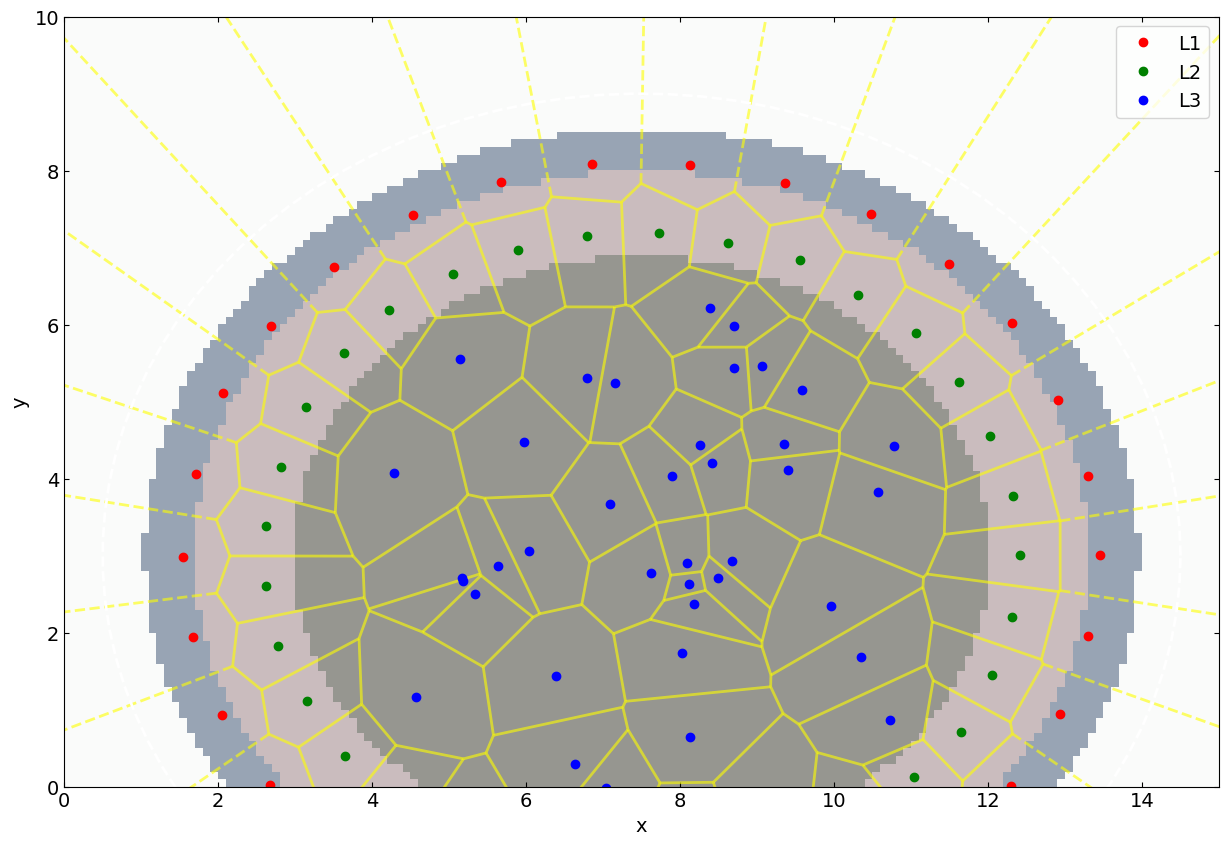

Plotting wusr with meristem boundary
Plotting wusr, Step 0
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


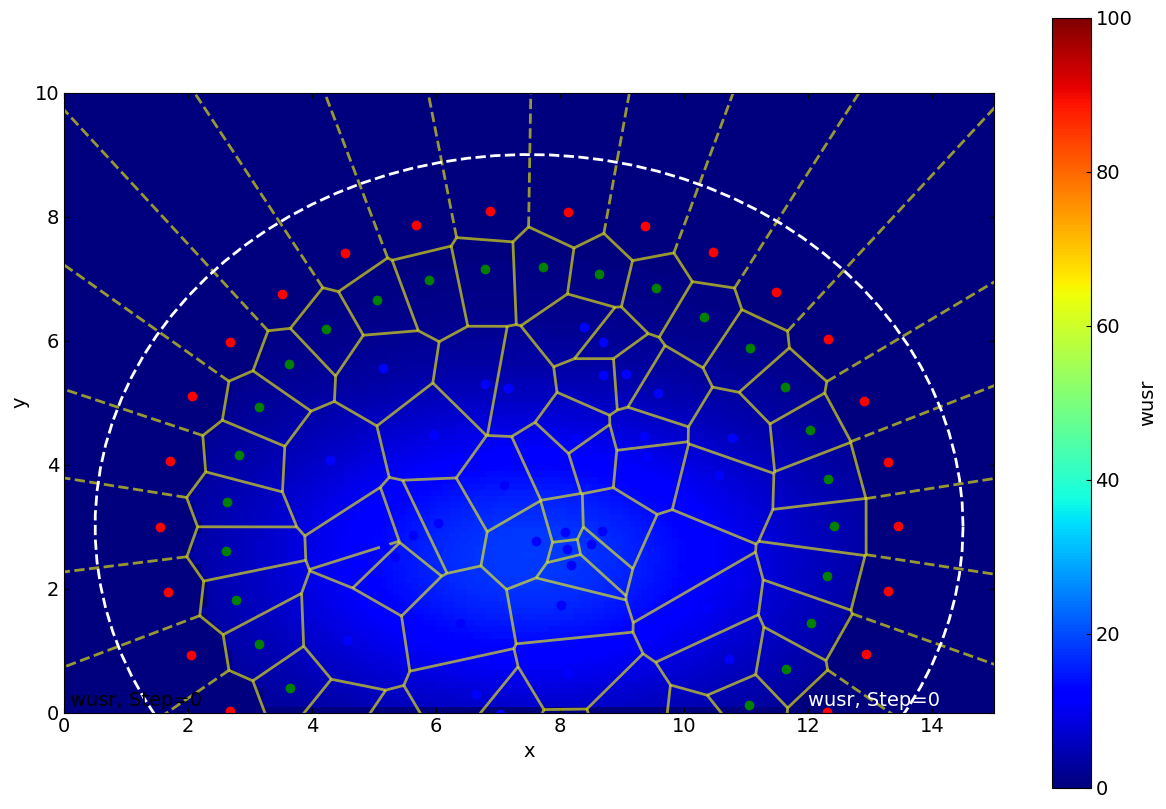

Plotting wusp with meristem boundary
Plotting wusp, Step 0
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


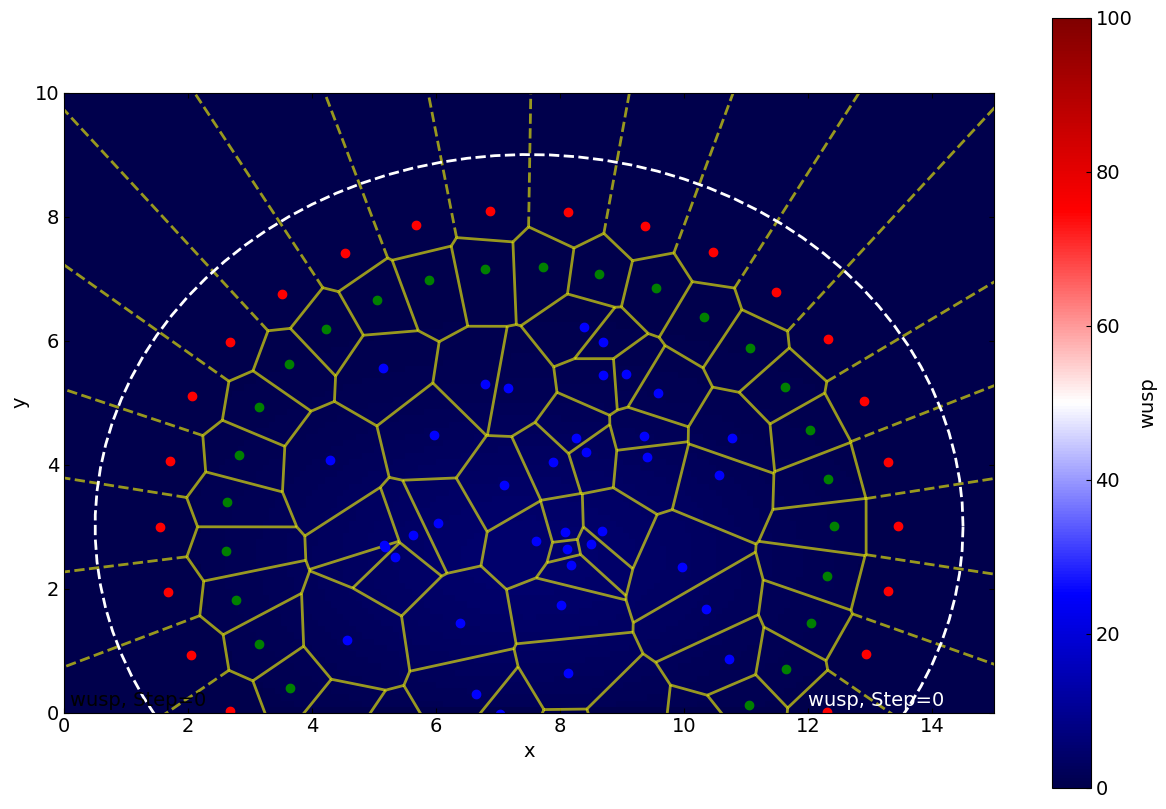

Plotting clvr with meristem boundary
Plotting clvr, Step 0
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


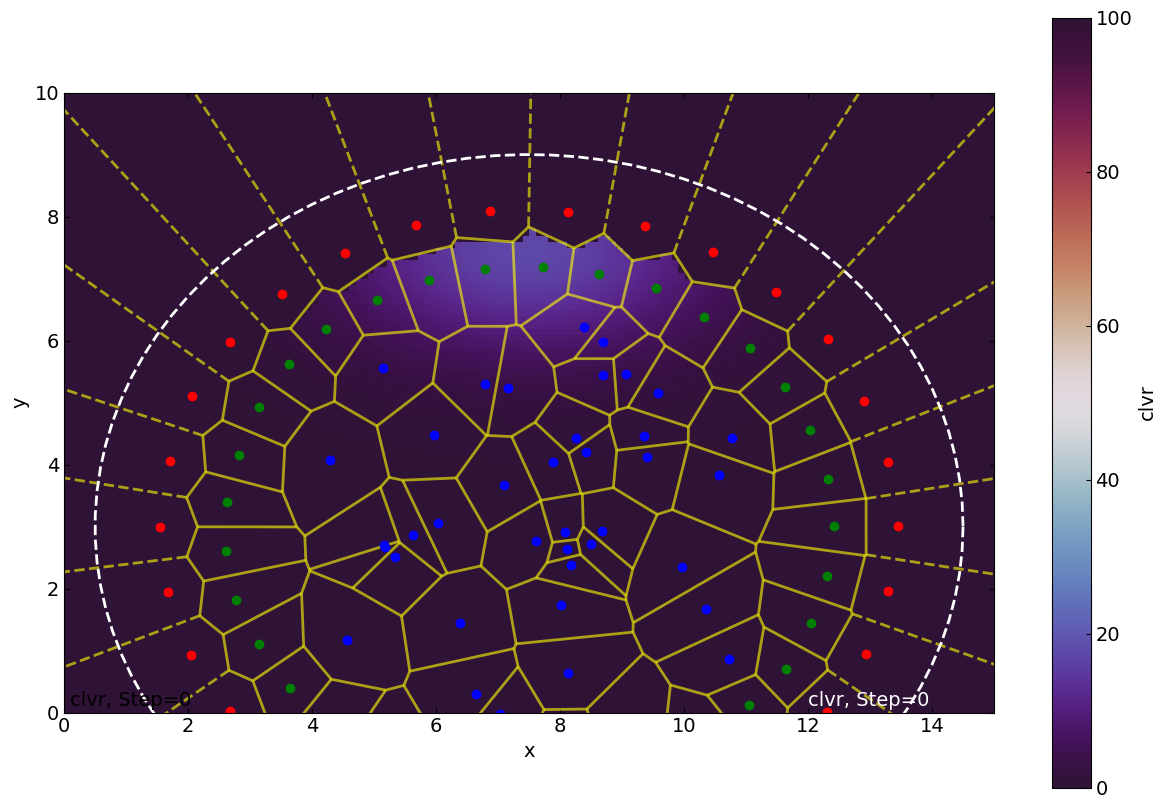

Plotting clvp with meristem boundary
Plotting clvp, Step 0
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


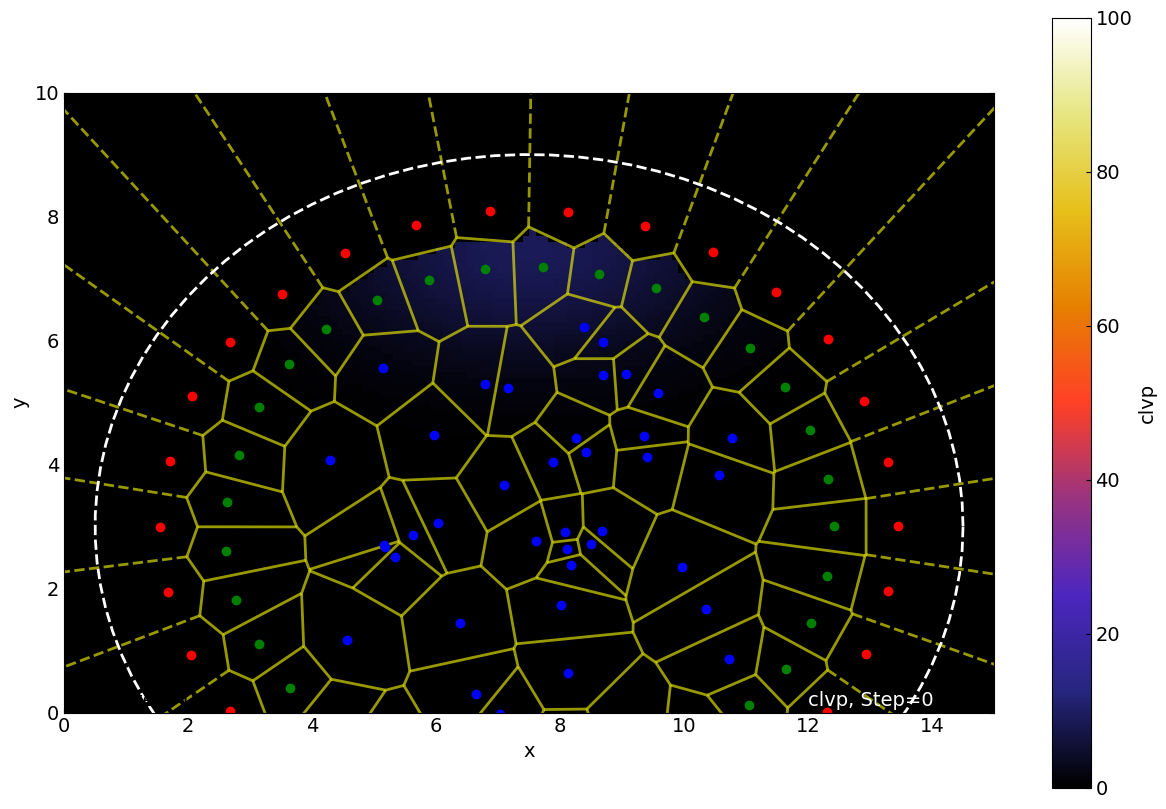

Plotting erfL with meristem boundary
Plotting erfL, Step 0
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


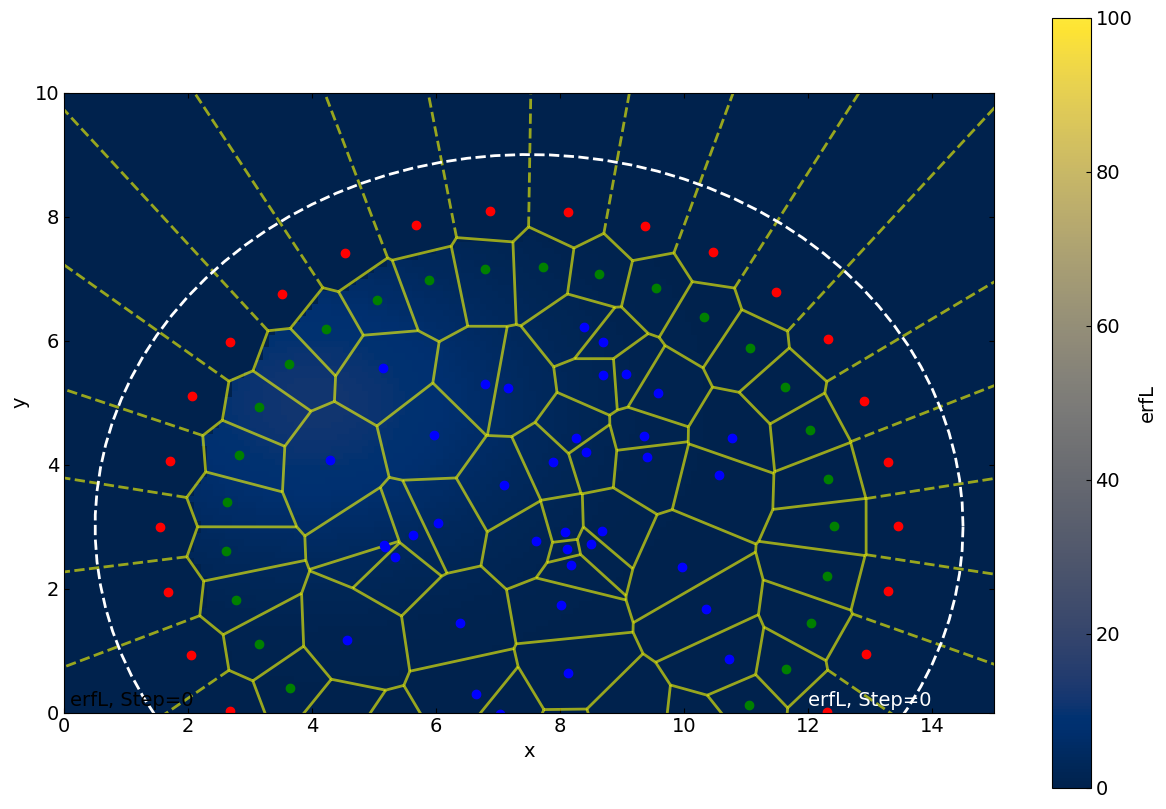

Plotting erfR with meristem boundary
Plotting erfR, Step 0
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


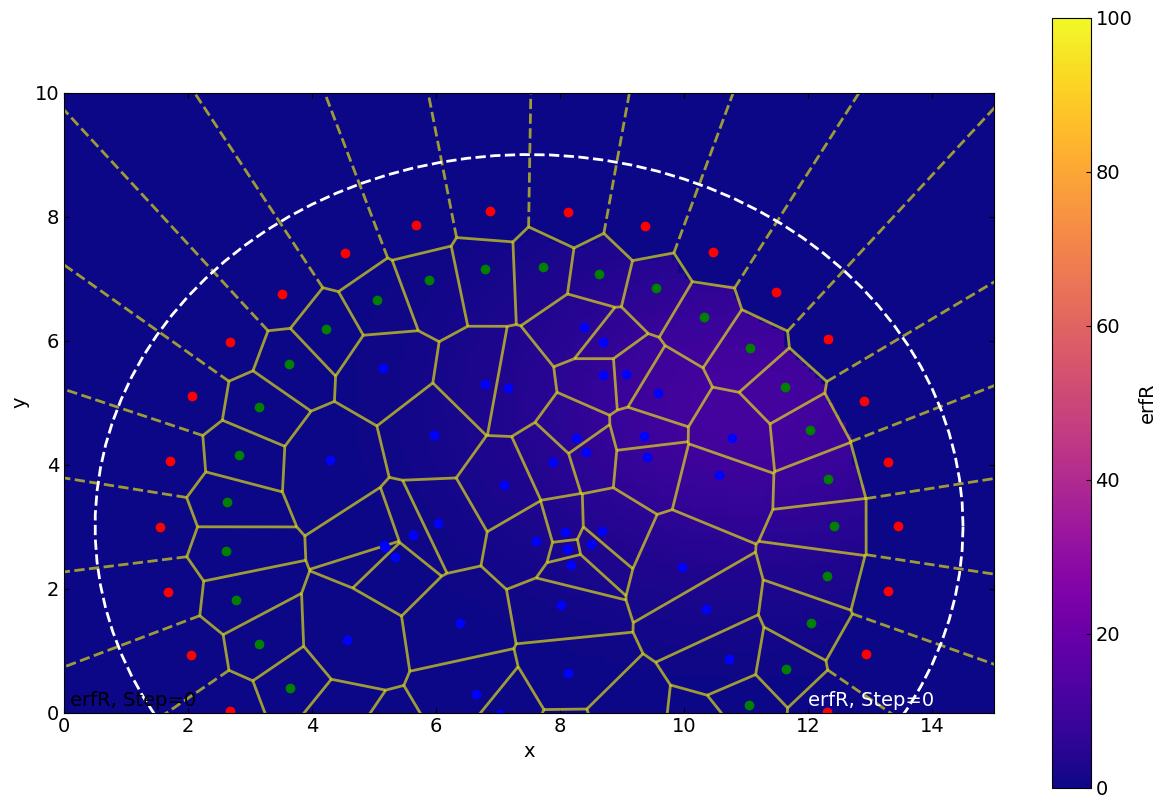

Plotting ham with meristem boundary
Plotting ham, Step 0
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


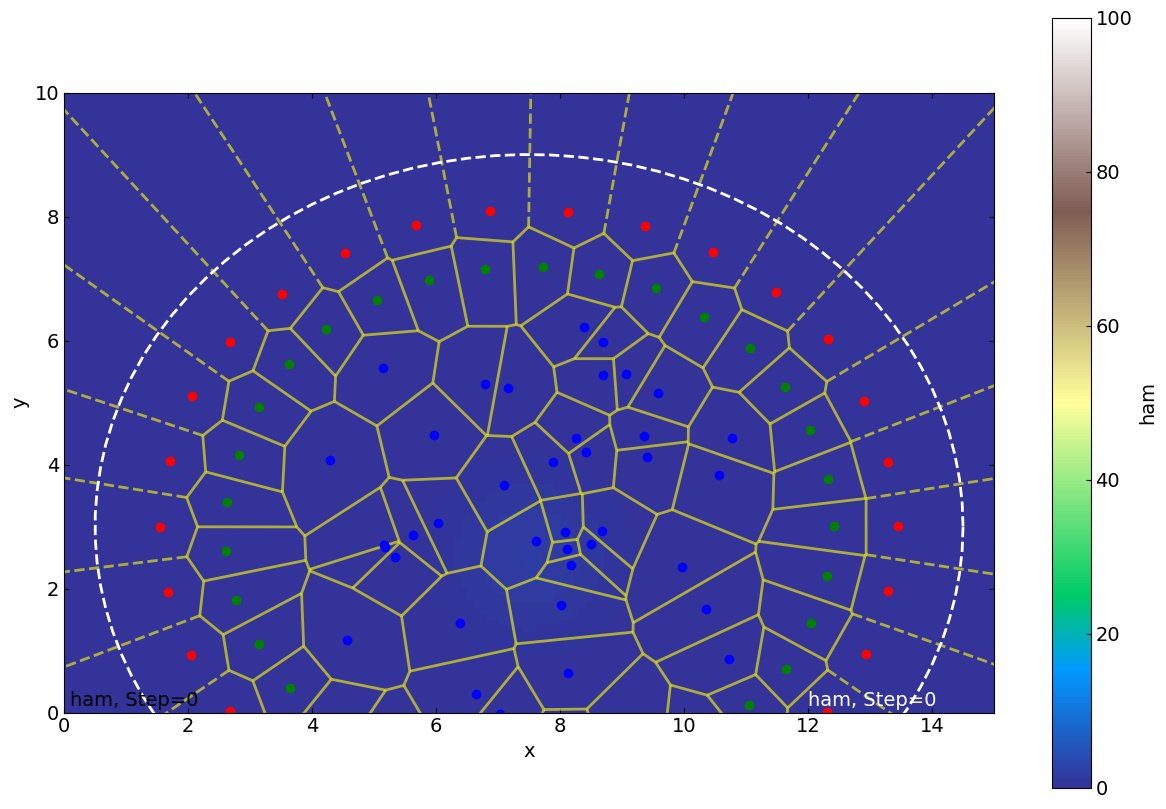

Step 0: Cell info and simulation results have been plotted.
Plotting cell_info
Plotting cell_info, Step 5
vor: Provided
points: Provided
layers: Provided
simulation_mask: Provided
layer_mask_L1: Provided
layer_mask_L2: Provided
layer_mask_L3: Provided


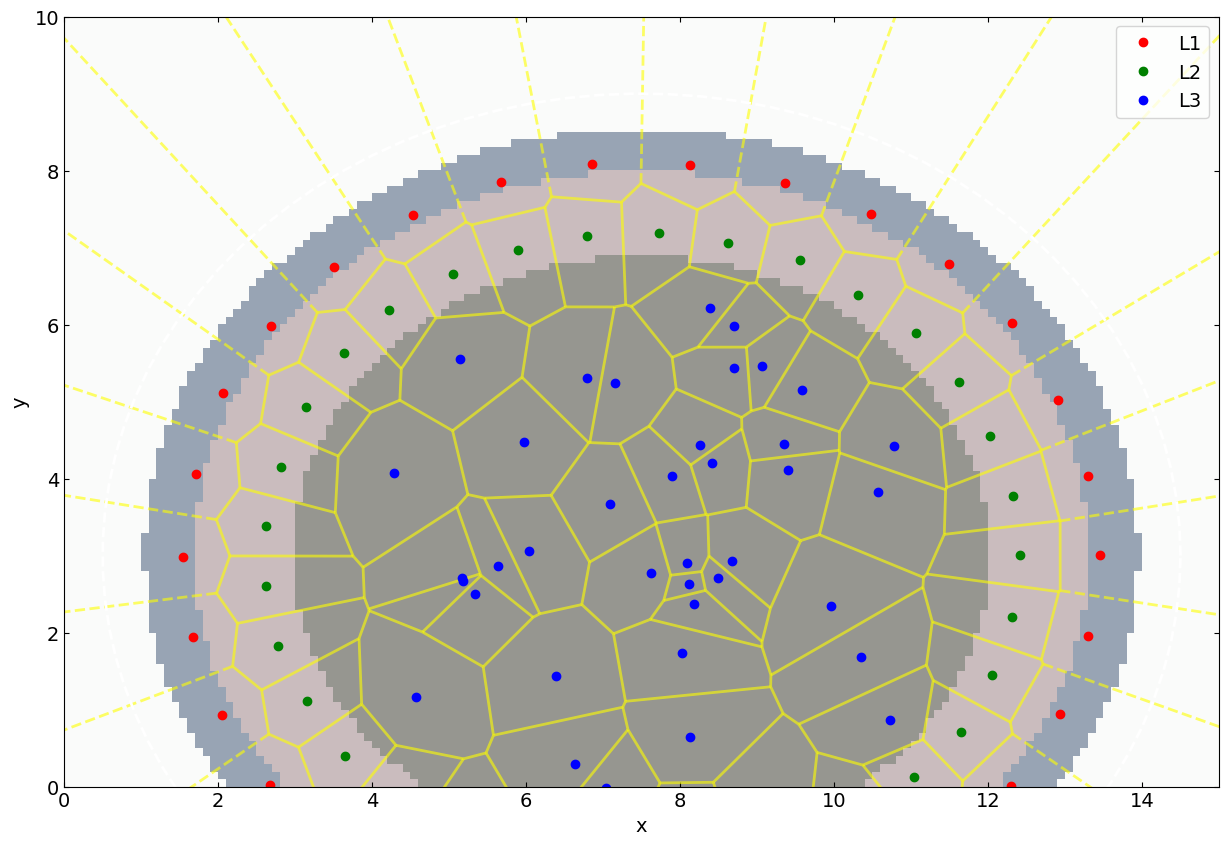

Plotting wusr with meristem boundary
Plotting wusr, Step 5
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


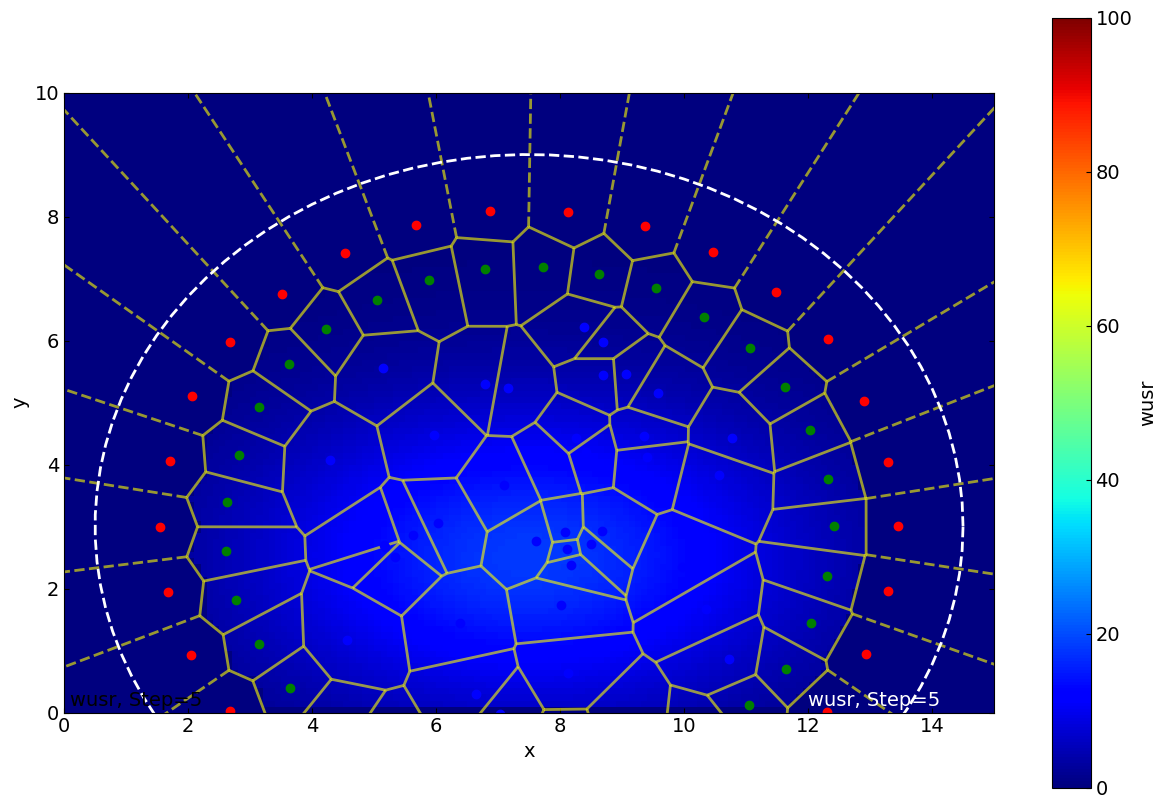

Plotting wusp with meristem boundary
Plotting wusp, Step 5
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


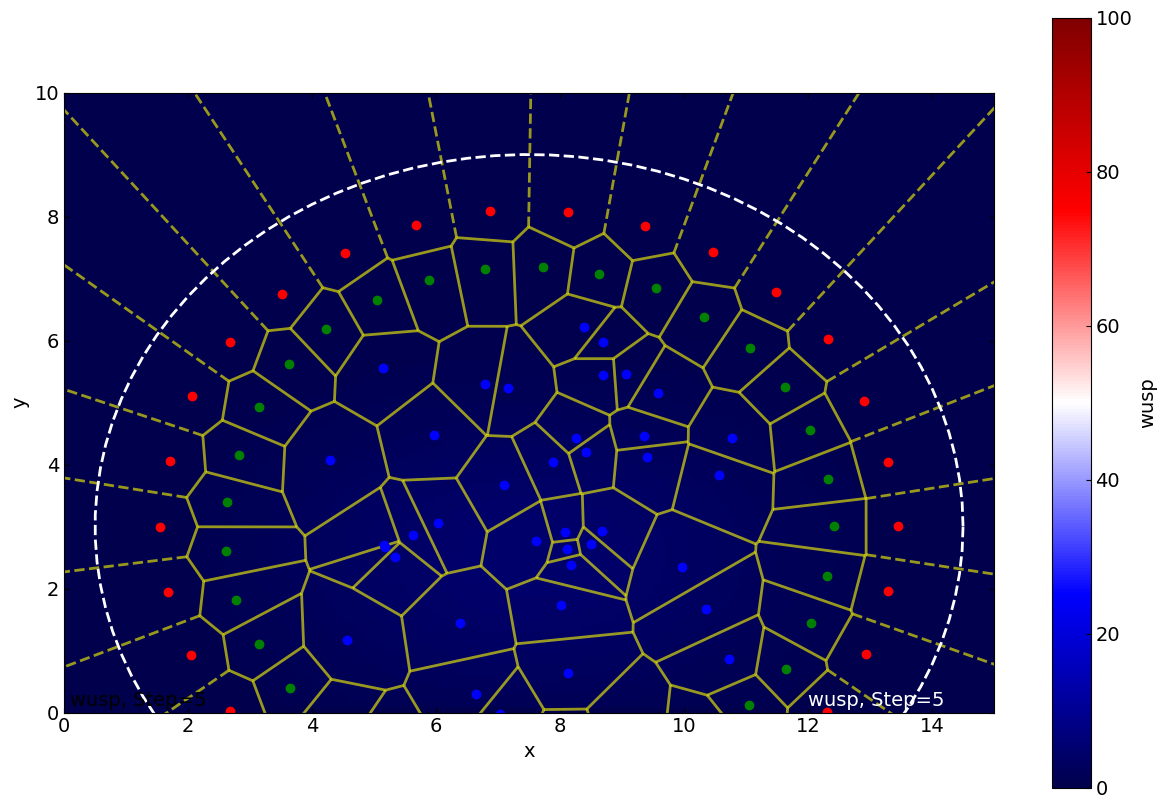

Plotting clvr with meristem boundary
Plotting clvr, Step 5
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


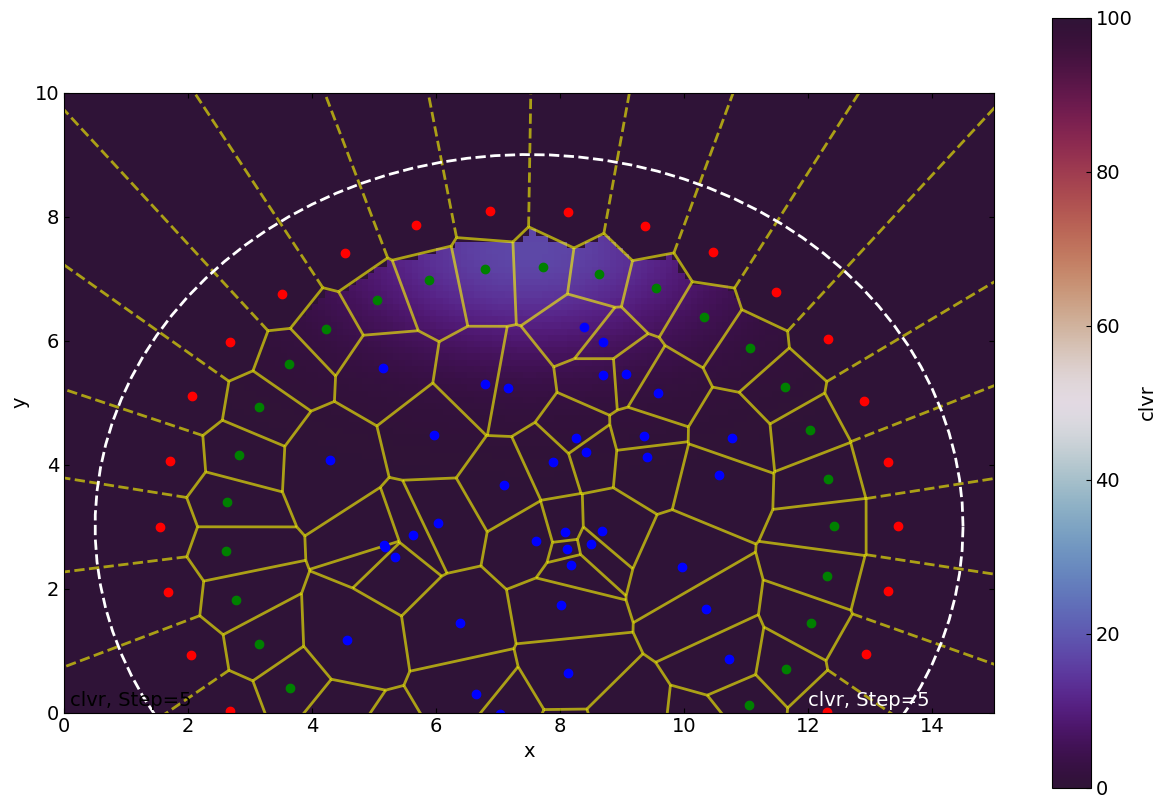

Plotting clvp with meristem boundary
Plotting clvp, Step 5
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


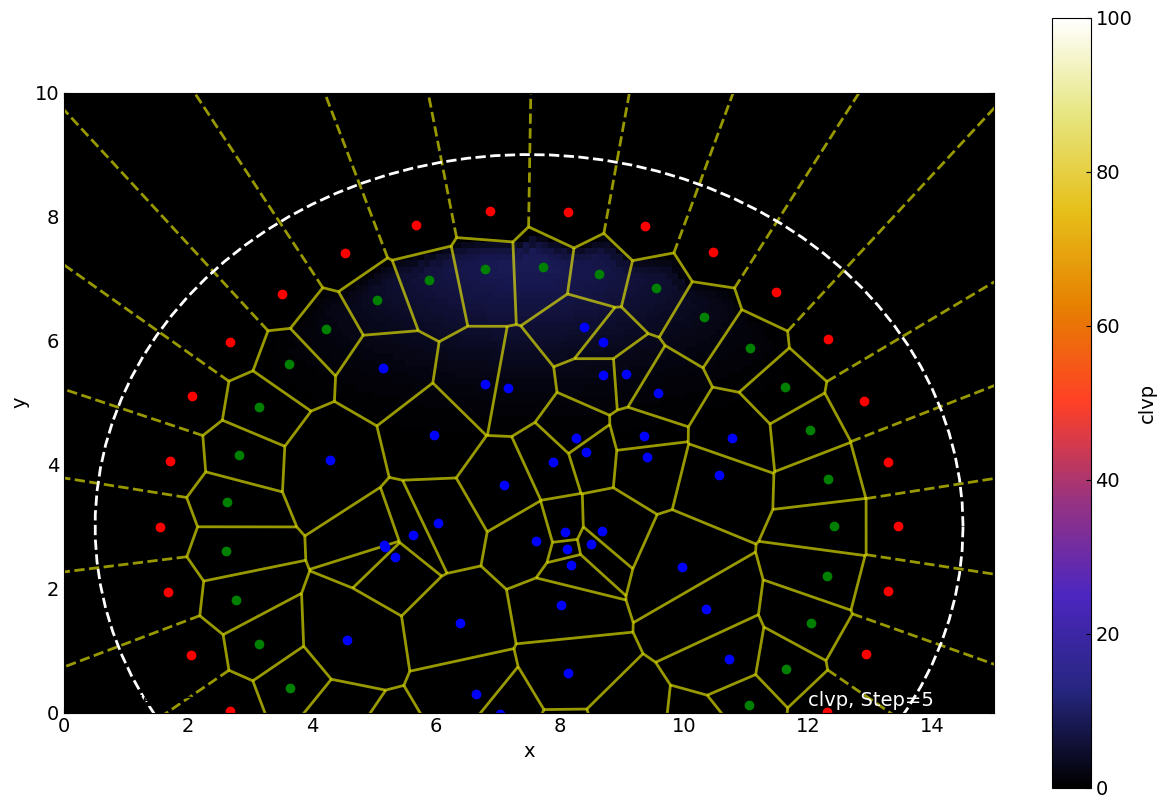

Plotting erfL with meristem boundary
Plotting erfL, Step 5
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


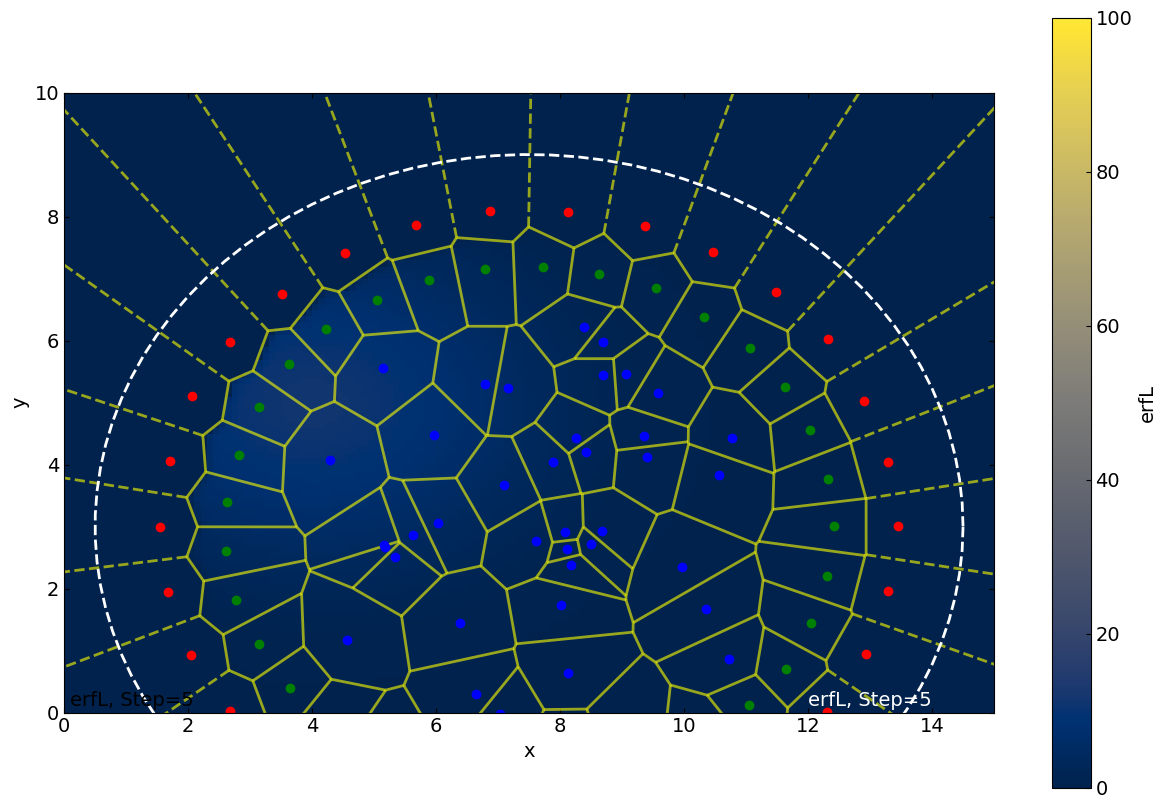

Plotting erfR with meristem boundary
Plotting erfR, Step 5
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


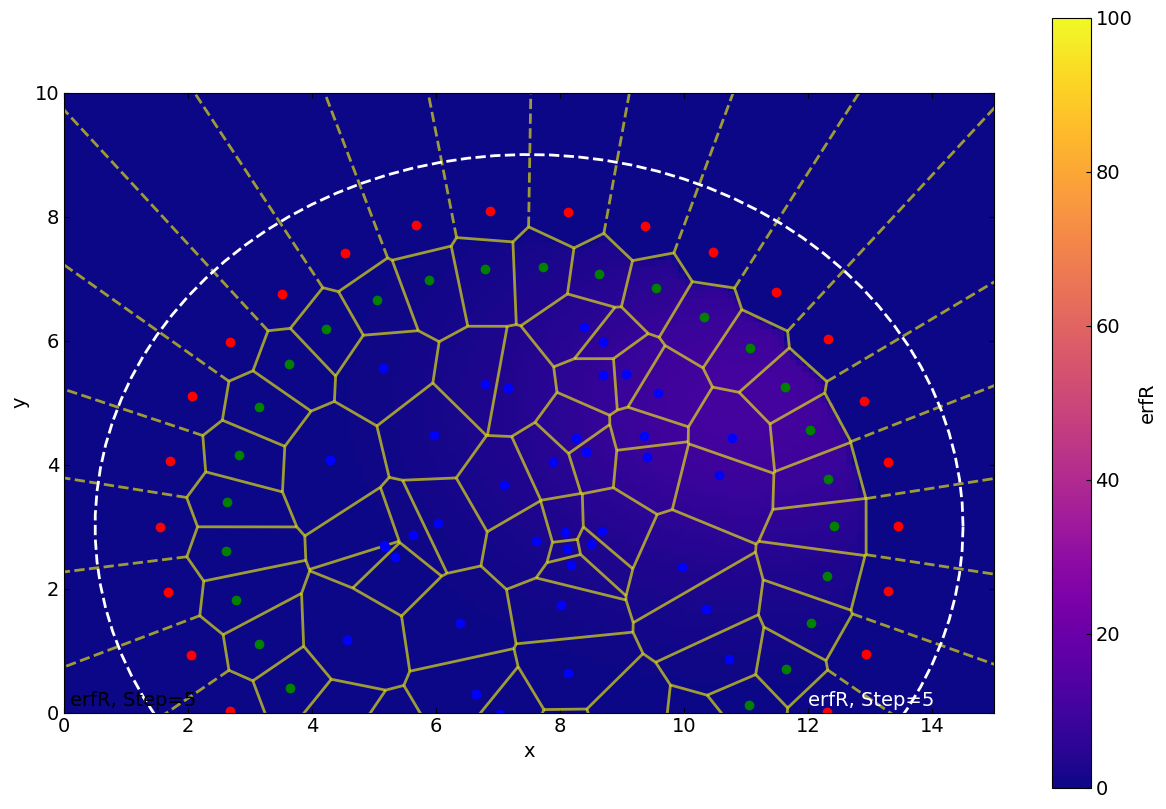

Plotting ham with meristem boundary
Plotting ham, Step 5
vor: Provided
points: Provided
layers: Provided
simulation_mask: None
layer_mask_L1: None
layer_mask_L2: None
layer_mask_L3: None


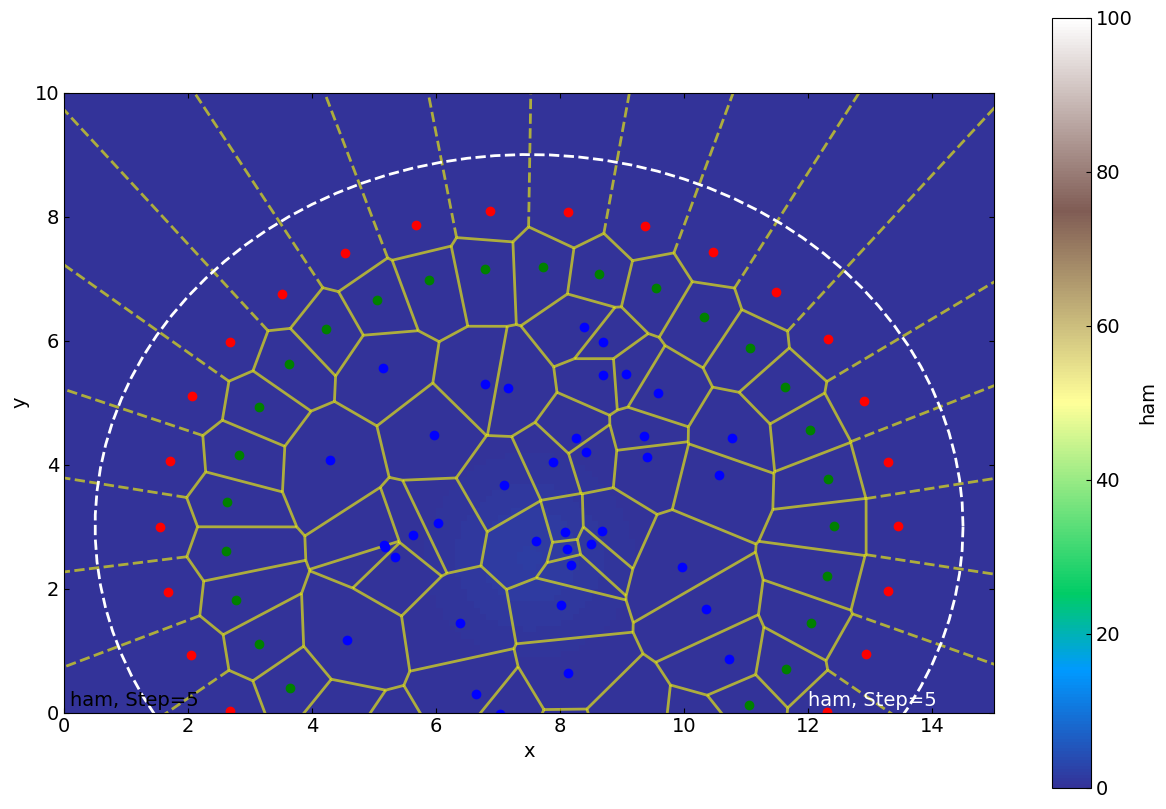

Step 5: Cell info and simulation results have been plotted.


In [ ]:
# 初期フィールドの生成
x, y = np.linspace(0, x_max, int(x_max / dx)), np.linspace(0, y_max, int(y_max / dy))
wusr, wusp, clvr, clvp, erfL, erfR, ham = initial_field(x, y)

# 初期ステップ (n=0) のシミュレーション領域マスクとレイヤーマスクの作成
initial_radius = radius_func(0)
simulation_mask = meristem_boundary_mask(x, y, ellip_x, ellip_y, lambda: initial_radius)

# レイヤーマスクの作成（楕円の縮小率を使用）
shift_factor_L1 = 0.9  # L1層の楕円の縮小率
shift_factor_L2 = 0.7  # L2層の楕円の縮小率

# L1層のマスク
layer_mask_L1 = meristem_boundary_mask(
    x, y, ellip_x, ellip_y, lambda: initial_radius * shift_factor_L1
)

# L2層のマスク
layer_mask_L2 = meristem_boundary_mask(
    x, y, ellip_x, ellip_y, lambda: initial_radius * shift_factor_L2
)

# L3層のマスク（シミュレーション領域からL1とL2を除外）
layer_mask_L3 = simulation_mask & ~layer_mask_L1 & ~layer_mask_L2

# 境界条件を設定する
wusr = boundary_condition(wusr)
wusp = boundary_condition(wusp)
clvr = boundary_condition(clvr)
clvp = boundary_condition(clvp)
erfL = boundary_condition(erfL)
erfR = boundary_condition(erfR)
ham = boundary_condition(ham)

# メリステム外の初期フィールドをゼロに設定
wusr[~simulation_mask] = 0
wusp[~simulation_mask] = 0
clvr[~simulation_mask] = 0
clvp[~simulation_mask] = 0
erfL[~simulation_mask] = 0
erfR[~simulation_mask] = 0
ham[~simulation_mask] = 0

# 安定性の確認
nu_x, nu_y = a * dt / dx ** 2, a * dt / dy ** 2
print('nu_x, nu_y=', nu_x, nu_y)

# シードポイントの生成
points_list = seed_points_maker(
    ellip_x=ellip_x,
    ellip_y=ellip_y,
    ellip_long=ellip_long,
    ellip_short=ellip_short,
    num_L1=30,  # L1 層のポイント数（調整可能）
    num_L2=33,  # L2 層のポイント数（調整可能）
    num_L3=40   # L3 層のポイント数（調整可能）
)

# ポイントの座標と属性を取得
points = np.array([[p['x'], p['y']] for p in points_list])
layers = [p['layer'] for p in points_list]

# シミュレーションの実行時に分裂を無効化
divide_active = False  # 一時的に分裂を無効化

pull_sol = [dt, dx, dy, a, step, result_interval]
ID = 0
results, points, vor, layers = sol_diffusion(
    x, y, wusr, wusp, clvr, clvp, erfL, erfR, ham,
    pull_sol, ID, points_list, layers,
    divide_active=divide_active
)

# プロファイリングの実行
pr = cProfile.Profile()
pr.enable()

# 実行する関数
# 注意: ここでは再度 `sol_diffusion` を呼び出さないように修正

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats(10)  # 上位10個の関数を表示
print(s.getvalue())

# 結果のプロット
plot_diffusion(x, y, results, points, vor, layers,
              ellip_x, ellip_y, ellip_long, ellip_short, ID,
              layer_mask_L1, layer_mask_L2, layer_mask_L3, simulation_mask)
